In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import time
import os
import imageio
import os
from tqdm import tqdm

from scipy import stats

# sns.set_context('notebook', font_scale=1)
# sns.set_style('darkgrid')
# sns.set_palette('Paired')
import imageio.v3 as iio


#### Algorithm

- Initialize length of the trial $T = 250 ms$
- Initialize stimulus time series $u(t) = \delta(t - t_{s})$, $t \in [0, T] $ ms, $t_{stimulus} = 100 $ ms
- Initialize reward time series $r(t) = r_0 \delta(t - t_{r})$, $t \in [0, T] $ ms, $t_{reward} = 200 $ ms
- Initialize weights $w(\tau)$, $\tau \in [0, T] ms$ for convolution
- Initialize learning rate $\eta = 0.05$

> For each trial:
1. Convolve weights with stimulus time series -> get estimate of future reward $v(t)$ for each time point
2. Compute error $\delta(t) = r(t) + v(t+1) - v(t)$ for each timepoint in trial
3. Update weights by the delta rule: $$ w(\tau) \leftarrow w(\tau) + \eta \cdot \delta(t) \cdot  u(t - \tau)$$


where $\delta(t)$ is error for timepoint $t$ in trial, while $u(t - \tau)$ is stimulus at time point $t - \tau$

Should it be **intra-trial** learning or **between-trial** learning of weights??

### Stimulus and reward generating functions

**Stimulus time series**

Usually 1 when there is stimulus and 0 otherwise.

**Reward time series**

Deterministic reward:
- Delta-function reward: $ r(t_r) = R_0 $
- Deterministic reward is spread over time $ r(t) \sim Norm(t_r, scale^{t}_r) $, $\sum r(t) = R_0$
- Two rewards $r(t_1) + r(t_2) = R_0$


Stochastic reward. Main feature: $$ \mathbb{E}\left[\sum_t r(t)\right] = R_0 $$

- Gaussian reward amount each trial: $ r(t_r) \sim Norm(R_0, scale^{r}_{R_0}) $
- Bernoulli reward each trial (sometimes get, sometimes not): $r(t_r) \sim Bern(p) \cdot R_0 / p $
- Random choice between two rewards: $p r(t_1) + (1 - p)r(t_2) = R_0$

In [4]:
class TDLearner:
    
    def __init__(self, T, reward_params, stimulus_params, learning_rate=0.4):
        """ Initializes TDLearner object, timegrid and reward/stimulus parameters"""
        
        self.times = np.arange(T)
        self.T = T
        self.learning_rate = learning_rate
        self.reward_params   = reward_params
        self.stimulus_params = stimulus_params
        
        self.trialWeights = []
        self.trialValues = []
        self.trialErrors = []
        self.trialRewards = []
        
        self.stimuli = self.generate_stimulus_timeseries(**stimulus_params)
        # the reward time series are generated within each trial
        
        
    def oneTrial(self, verbose=False):
        
        # set reward and stimulus timeseries for a trial
        rewards = self.generate_reward_timeseries(**self.reward_params)
        stimuli = self.stimuli
        
        # if it is the first trial, initialize weights as zeros
        if len(self.trialWeights) == 0:
            weights = np.zeros_like(self.times, dtype=np.float32)
        else:
            weights = self.trialWeights[-1]
        
        # initialize trial TD-errors and values as zeros (they will be computed in the next steps)
        errors = np.zeros_like(self.times, dtype=np.float32)
        values = np.zeros_like(self.times, dtype=np.float32)

        # compute estimates of future rewards
        values = np.convolve(weights, stimuli, mode='full')[:-len(weights)+1] # cut the irrelevant part due to convolution properties

        # calculate prediction error 
        errors[:-1] = rewards[:-1] + values[1:] - values[:-1]  # not taking into account the last point as value[T] is not defined

        # update weights  
        for tau in range(self.T):
            for t in range(tau, self.T):
                weights[tau] = weights[tau] + self.learning_rate * errors[t] * stimuli[t - tau]
                
            t_string = str(t // 10) + str(t % 10)
            if verbose: print(f"{t_string} ms: r = {rewards[t]}, u = {stimuli[t]}; w = {weights}; delta = {errors[t]}; v = {values[t]}")

        self.trialWeights.append(weights)
        self.trialValues.append(values)
        self.trialErrors.append(errors)
        self.trialRewards.append(rewards)
        
        
    def learn(self, n_trials, verbose=False):
        for i in range(n_trials):
            self.oneTrial(verbose=verbose)
            
            
    def clear_learning_progress(self):
        self.trialWeights = []
        self.trialValues = []
        self.trialErrors = []
        self.trialRewards = []
        
        
    def plot_trial(self, i_trial, ax=None):
        """returns figure which could be saved"""
        pass
    
    
    def plot_3d(self, ax=None):
        pass
    
    
    def animate(self):
        pass
        
        
    def generate_stimulus_timeseries(self, t_stimulus):
        """
        Generates stimulus time series. 1 - stimulus, 0 - no stimulus.

        Parameters: 
            times: ndarray
            t_stimulus: (int,) | arrayLike
        Returns:
            u: np.array, shape (len(times), )
        """
        times = self.times
        assert t_stimulus < T, "t_stimulus is out of time grid"
        u = np.zeros(len(times))
        u[t_stimulus] = 1

        return u


    def generate_reward_timeseries(self, R0, type_reward, t_reward, scale_t=3, scale_r=2., p=0.8):
        """
        Generates reward time series for each trial.

        Parameters: 
            R0: int
                The expectation of a total reward during the trial
            type_reward: str
                Chooses the reward type:

                "det_delta" - deterministic delta function reward r(t_reward) = R0
                "det_gauss" - deterministic (discrete) gaussian spread reward with peak in t_reward and sum(r(t)) = R0.
                # scale_t should be specified
                "det_multiple" - delta functions with sum(r_t) = R0
                # "probability" p will be chosen as a ratio between two rewards

                "stoch_gauss" - gaussian distributed amount of reward each trial
                # scale_r should be specified.
                "stoch_bern" - sample from bernoulli distribution with mean reward equals R0
                # probability p should be specified.
                "stoch_multiple" - random choice between two rewards with expectation = R0
                # probability p should be specified

            t_reward: int or arrayLike
                max(len(t_reward)) = 2
            scale_t: int, default 3
            scale_r: float, default 2.
            p: float, default 0.8
            random_state: int, default 1

        Returns:
            r: np.array, shape (len(times), )
        """
        times = self.times
        assert np.max(t_reward) < np.max(times), "t_reward is out of time grid! "
        assert np.size(t_reward) <= 2, "Currently only two reward times is supported by multiple reward methods..."

        r = np.zeros(len(times))

        if type_reward == "det_delta":
            assert isinstance(t_reward, int), f"Method {type_reward} does not support multiple reward times"
            r[t_reward] = R0

        elif type_reward == "det_gauss":
            assert isinstance(t_reward, int), f"Method {type_reward} does not support multiple reward times"
            t_slice = slice(t_reward - scale_t, t_reward + scale_t + 1, times[1] - times[0])
            gaussian_pdf = stats.norm(loc=t_reward, scale=1/3 * scale_t).pdf(times[t_slice])
            r[t_slice] = gaussian_pdf
            norm_factor = np.sum(r)
            r *= (R0 / norm_factor)

        elif type_reward == "det_multiple":
            assert np.size(t_reward) == 2, f"Two time points must be specified for {type_reward} method."
            r[t_reward[0]] = p * R0
            r[t_reward[1]] = (1 - p) * R0

        elif type_reward == "stoch_gauss":
            assert isinstance(t_reward, int), f"Method {type_reward} does not support multiple reward times"
            R0_stoch = stats.norm(loc=R0, scale=scale_r).rvs()
            r[t_reward] = R0_stoch


        elif type_reward == "stoch_bern":
            assert isinstance(t_reward, int), f"Method {type_reward} does not support multiple reward times"
            norm_factor = R0 / p
            r[t_reward] = norm_factor * stats.bernoulli(p=p).rvs()

        elif type_reward == "stoch_multiple":
            assert np.size(t_reward) == 2, f"Two time points must be specified for {type_reward} method."
            chosen_t = np.random.choice(t_reward, p=[p, 1 - p])
            r[chosen_t] = R0


        elif type_reward == "no_reward":
            pass

        else:
            raise ValueError(f"type_reward={type_reward} does not exist. Please specify the valid one") 
        
        return r 

### Main TD-function

In [58]:
%%time

T = 50
learning_rate = 0.3
n_trials = 200
stimulus_params = {"t_stimulus": 10}

reward_params   = {"R0": 5, 
                   "type_reward": "det_delta", 
                   "t_reward": 30, 
                   "scale_t": 6, 
                   "scale_r": 2, 
                   "p": 0.3}




learner = TDLearner(T, reward_params, stimulus_params, learning_rate)
learner.learn(n_trials)

CPU times: total: 2.47 s
Wall time: 2.46 s


#### Creating GIFs

In [59]:
%matplotlib inline

subfolder = "gif_" + learner.reward_params['type_reward']
try:
    os.mkdir(subfolder)
except:
    pass

for i_trial in tqdm(range(n_trials)):
    fig, ax = plt.subplots()

    ax.plot(learner.times, learner.trialValues[i_trial], linewidth=2, label='value-function')
    ax.plot(learner.times, learner.trialErrors[i_trial], linewidth=2, label='error-delta')
    ax.plot(learner.times, learner.trialRewards[i_trial], linewidth=2, linestyle='--', label='reward')
    ax.set_xlabel('timestep')
    ax.legend()

    lim_low = np.min(np.min(np.array(learner.trialErrors))) - 0.5
    lim_high = np.max(np.max(np.array(learner.trialValues))) + 0.5
    ax.set_ylim((lim_low, lim_high))
    #i_trial_str = str(i_trial // 100) + str(i_trial // 10) + str(i_trial % 10)
    fpath = os.path.join(subfolder, f"trial{i_trial}.png")
    plt.savefig(fpath, dpi=150, bbox_inches='tight')
    plt.close()

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:43<00:00,  4.57it/s]


In [60]:
frames = np.stack([iio.imread(os.path.join(subfolder, f"trial{i_trial}.png")) for i_trial in range(n_trials)], axis=0)

gif_path = learner.reward_params['type_reward'] + '.gif' 
iio.imwrite(gif_path, frames, duration=5)

In [21]:
%matplotlib widget
import matplotlib.animation as animation

plt.rcParams['image.cmap'] = 'rainbow'

with plt.style.context('default'):
    fig, ax = plt.subplots()

    line1, = ax.plot(learner.times, learner.trialValues[0], label='value-function')
    line2, = ax.plot(learner.times, learner.trialErrors[0], label='error-delta')
    line3, = ax.plot(learner.times, learner.trialRewards[0], label='reward')
    ax.legend()

    lim_low = np.min(np.min(np.array(learner.trialErrors))) - 0.5
    lim_high = np.max(np.max(np.array(learner.trialValues))) + 0.5
    ax.set_ylim((lim_low, lim_high))

    def animate(i_trial):
        line1.set_ydata(learner.trialValues[i_trial])
        line2.set_ydata(learner.trialErrors[i_trial])
        line3.set_ydata(learner.trialRewards[i_trial])
        return [line1, line2]


    ani = animation.FuncAnimation(
        fig, animate, interval=100, blit=True, save_count=50)

Text(0.5, 0.5, 'Trials')

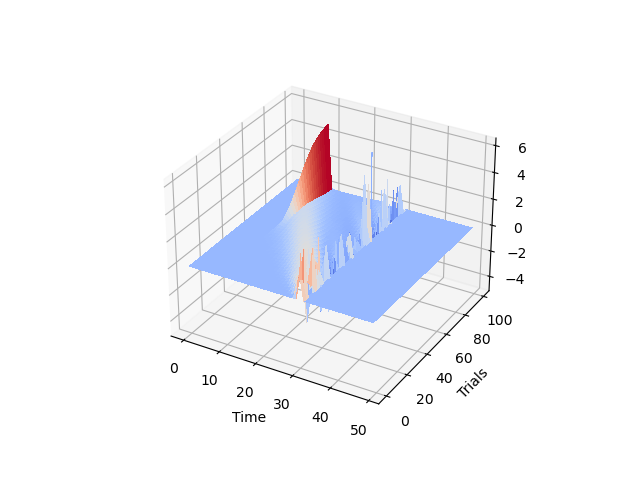

In [11]:
%matplotlib widget

Y = np.arange(n_trials)
X = learner.times

X_mesh, Y_mesh = np.meshgrid(X, Y)
Z = np.array(np.array(learner.trialErrors))

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(X_mesh, Y_mesh, Z, cmap = cm.coolwarm, linewidth=0, antialiased=False)

#surf = ax.stem(X, Y, Z)
ax.set_xlabel("Time")
ax.set_ylabel("Trials")

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)

In [202]:
%%time

T = 80

# init stimulus params
t_stimulus = 20

# init reward params
t_reward = 60
R0 = 5
total_reward = R0        # value at the point of maximum reward (loc)
gaussian_reward = True   # shape of the distribution. the variance spans time rather than amount of the reward
stochastic_reward = True # makes reward R0 distributed around t_reward with gaussian pdf and scale = scale_reward
scale_reward = 3         # relevant only if reward is gaussian
stochastic_R0 = True

N_trials = 250
lr = .4
verbose = False

times = np.arange(T)

# init stimulus
u = np.zeros_like(times)
u[t_stimulus] = 1

# init rewards
r = np.zeros_like(times, dtype=np.float32)
r[t_reward] = R0

# gaussian rewards
if gaussian_reward:
    t_slice = slice(t_reward - scale_reward, t_reward + scale_reward + 1, times[1] - times[0])
    gaussian_pdf = stats.norm(loc=t_reward, scale=1/3 * scale_reward).pdf(times[t_slice])
    r[t_slice] = R0 / np.max(gaussian_pdf) * gaussian_pdf
    total_reward = np.sum(r[t_slice])


# init weights
w = np.zeros(T)

# init empty lists for storing and analysis
w_trials = []
v_trials = []
d_trials = []

for trial in range(N_trials):
    if verbose: print("TRIAL #", trial)
    
    # initialize error and value arrays
    delta = np.zeros_like(times, dtype=np.float32)
    v = np.zeros_like(times, dtype=np.float32)
    
    # compute estimates of future rewards
    v = np.convolve(w, u, mode='full')[:-len(w)+1] # cut the irrelevant part
    
    
    # aalculate prediction error 
    delta[:-1] = r[:-1] + v[1:] - v[:-1]
    
    # update weights  
    for tau in range(T):
        for t in range(T):
            w[tau] = w[tau] + lr * delta[t] * u[t - tau]
        t_string = str(t // 10) + str(t % 10)
        if verbose: print(f"{t_string} ms: r = {r[t]}, u = {u[t]}; w = {w}; delta = {delta[t]}; v = {v[t]}")
        
        
    #w = w + lr * delta
    w_trials.append(w)
    v_trials.append(v)
    d_trials.append(delta)
    

CPU times: total: 8.86 s
Wall time: 8.86 s


In [141]:
print("Convolution testing")
w = np.zeros(10)
w[0:4] = np.arange(1, 5)
print("w: ", w)
u = np.zeros(10)
u[3] = 1
print("u: ", u)
v = np.convolve(w, u, mode='full')[:-len(w)+1]
print("v: ", v)

delta = np.zeros(10)
delta[7] = 9
print("d: ", delta)

print("Another type of update")
for tau in range(10):
    for t in range(10):
        w[tau] = w[tau] + 0.4 * delta[t] * u[t - tau]
        
print("w: ", w)

Convolution testing
w:  [1. 2. 3. 4. 0. 0. 0. 0. 0. 0.]
u:  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
v:  [0. 0. 0. 1. 2. 3. 4. 0. 0. 0.]
d:  [0. 0. 0. 0. 0. 0. 0. 9. 0. 0.]
Another type of update
w:  [1.  2.  3.  4.  3.6 0.  0.  0.  0.  0. ]


#### Animation

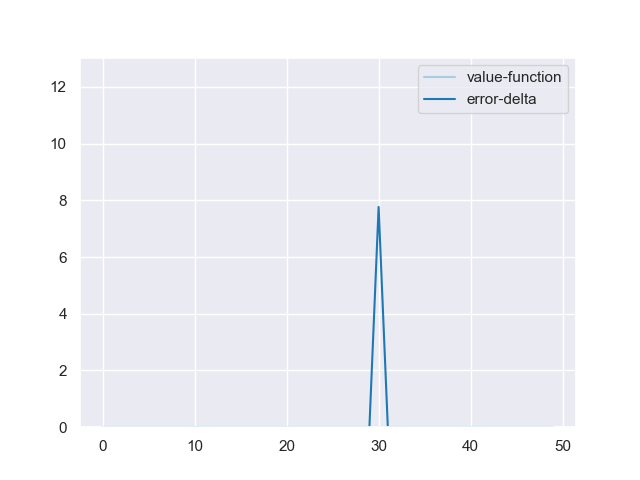

In [257]:
%matplotlib widget
import matplotlib.animation as animation

fig, ax = plt.subplots()

times = learner.times
v_trials = learner.trialValues
d_trials = learner.trialErrors

line1, = ax.plot(times, v_trials[0], label='value-function')
line2, = ax.plot(times, d_trials[0], label='error-delta')
#line3, = ax.plot(times, w_trials[0], label='weights')
ax.legend()
ax.set_ylim((0, total_reward + .5))

def animate(i_trial):
    line1.set_ydata(v_trials[i_trial])
    line2.set_ydata(d_trials[i_trial])
    return [line1, line2]


ani = animation.FuncAnimation(
    fig, animate, interval=200, blit=True, save_count=50)

#### Creating GIF

NameError: name 'u' is not defined

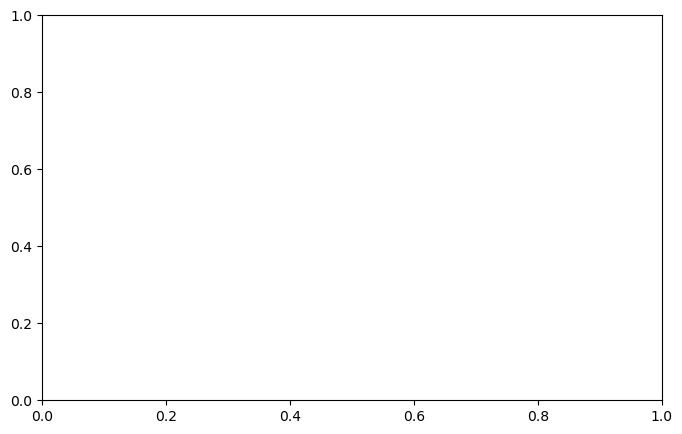

In [5]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(u, label='stimulus')
ax.plot(r, label='reward')
plt.show()

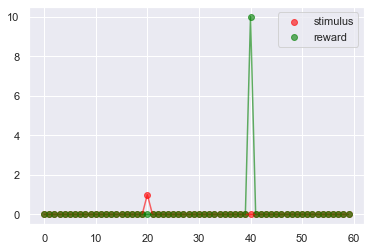

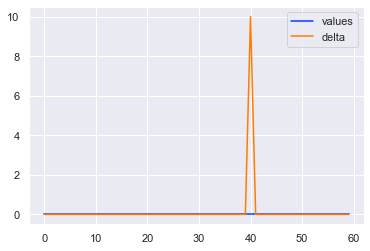

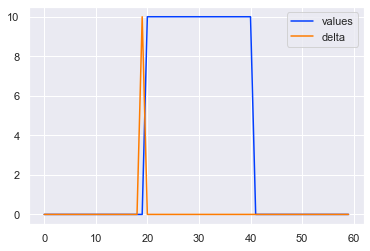

In [283]:
%matplotlib inline

ALPHA = 0.6
plt.scatter(times, u, label='stimulus', color='red', alpha=ALPHA)
plt.scatter(times, r, label='reward', color='green', alpha=ALPHA)
plt.legend()
plt.plot(times, u, label='stimulus', color='red', alpha=ALPHA)
plt.plot(times, r, label='reward', color='green', alpha=ALPHA)

plt.show()

plt.plot(v_trials[0], label='values')
plt.plot(d_trials[0], label='delta')
plt.legend()
plt.show()

plt.plot(v, label='values')
plt.plot(delta, label='delta')
plt.legend()
plt.show()


#### now remove the reward

In [286]:
r = np.zeros_like(times, dtype=np.float32)

# compute future reward estimate
#v = np.convolve(w, u, mode='full')[:-len(w)] # cut the irrelevant part
# compute error
delta = np.zeros_like(times, dtype=np.float32)
v = np.zeros_like(times, dtype=np.float32)

# compute estimates of future rewards
v = np.convolve(w, u, mode='full')[:-len(w) + 1] # cut the irrelevant part

# t_relevant = np.arange(t_stimulus, t_reward+1)
# v[t_relevant] = R_0


# compute errors
delta[:-1] = r[:-1] + v[1:] - v[:-1]

# learn (update weights)    
for t in range(T-1):
    tau = 0
    while tau < t:
        w[tau] = w[tau] + lr * delta[t] * u[t - tau]
        tau += 1
    t_string = str(t // 10) + str(t % 10)

w_trials.append(w)
v_trials.append(v)
d_trials.append(delta)

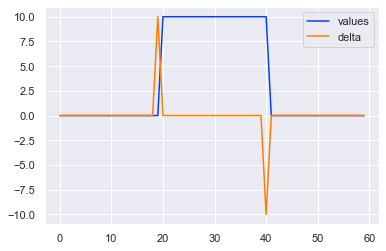

In [288]:
%matplotlib inline

plt.plot(v, label='values')
plt.plot(delta, label='delta')
plt.legend()
plt.show()

Text(0.5, 0, 'TD-error')

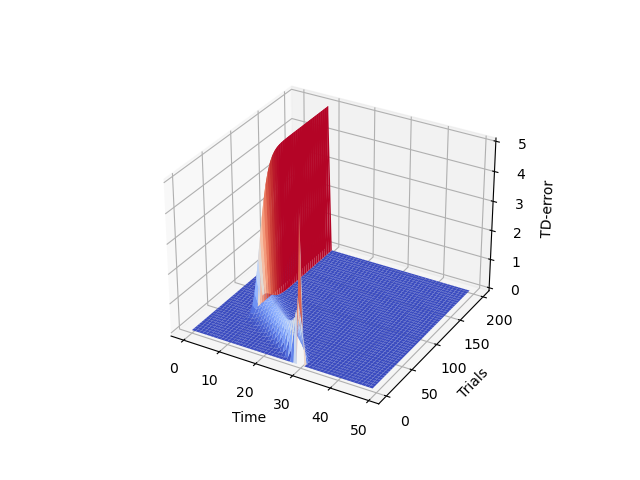

In [65]:
# plt.plot(u)
# plt.plot(r)
# plt.show()

%matplotlib widget

times = learner.times
v_trials = learner.trialValues
d_trials = learner.trialErrors

Y = np.arange(len(v_trials))
X = times

X_mesh, Y_mesh = np.meshgrid(X, Y)
Z = np.array(d_trials)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(X_mesh, Y_mesh, Z, cmap = cm.coolwarm, linewidth=0, antialiased=True)

#surf = ax.stem(X, Y, Z)
ax.set_xlabel("Time")
ax.set_ylabel("Trials")
ax.set_zlabel("TD-error")

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)


In [141]:
Z.shape

(20, 30)

### Implementation from BCCN

In [135]:
T = 30
R0 = 10
t_stimulus = 10
t_reward = 20
N_trials = 20
verbose = False

times = np.arange(T)

# init stimulus
u = np.zeros_like(times)
u[t_stimulus] = 1

# init rewards
r = np.zeros_like(times)
r[t_reward] = R0

# init weights
w = np.zeros_like(times)

lr = 1

# init empty lists for storing and analysis
w_trials = []
v_trials = []
d_trials = []

for trial in range(N_trials):
    if verbose: print("TRIAL #", trial)
    
    # compute future reward estimate
    #v = np.convolve(w, u, mode='full')[:-len(w)] # cut the irrelevant part
    # compute error
    delta = np.zeros_like(times)
    v = np.zeros_like(times)
    
    # compute estimates of future rewards
    v = np.convolve(w, u, mode='full')[:-len(w) + 1] # cut the irrelevant part
    
    for t in range(T - 1):
        
        # compute estimates
        # tau = 0
        # while tau < t:
        #     #if t - tau == 100: print("computing estimates")
        #     v[t] += w[tau] * u[t - tau]
        #     tau += 1
            
        if t == t_reward or t == t_stimulus:
            if verbose: print("v: ", v)
            
        # compute error
        delta[t] = r[t] + v[t + 1] - v[t]
        if t == 200: 
            if verbose: 
                print("reward: ", r[t])
                print("estimate: ", v[t])
                print("delta: ", delta[t])
        # learn (update weights)
        tau = 0
        
        t_string = str(t // 10) + str(t % 10)
        if verbose: print(f"{t_string} ms: r = {r[t]}, u = {u[t]}; w = {w}; delta = {delta[t]};")
    
    # update weights
    w = w + lr * delta * u
            
    w_trials.append(w)
    v_trials.append(v)
    d_trials.append(delta)
    

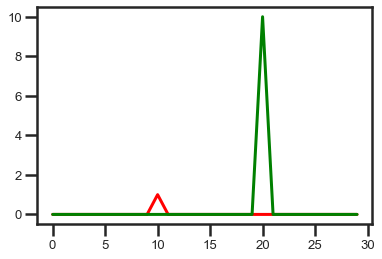

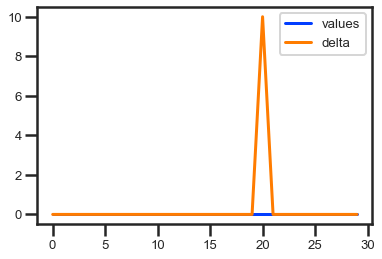

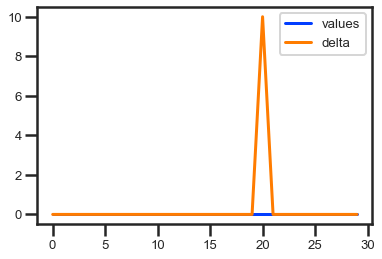

In [136]:
%matplotlib inline
plt.plot(u, label='stimulus', color='red')
plt.plot(r, label='reward', color='green')
plt.show()

plt.plot(v_trials[0], label='values')
plt.plot(d_trials[0], label='delta')
plt.legend()
plt.show()

plt.plot(v, label='values')
plt.plot(delta, label='delta')
plt.legend()
plt.show()


In [61]:
%matplotlib widget

Y = np.arange(n_trials)
X = times

X_mesh, Y_mesh = np.meshgrid(X, Y)
Z = np.array(d_trials)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(X_mesh, Y_mesh, Z, cmap = cm.coolwarm, linewidth=0, antialiased=False)

#surf = ax.stem(X, Y, Z)
ax.set_xlabel("Time")
ax.set_ylabel("Trials")

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)

NameError: name 'N_trials' is not defined

In [129]:
u = np.array([0, 0, 1, 0, 0, 0])
r = np.array([0, 0, 0, 5, 0, 0])
w = np.array([0, 5, 5, 5, 0, 0])

np.convolve(w, u)[:-5]

array([0, 0, 0, 5, 5, 5])

In [44]:
w

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

<StemContainer object of 3 artists>

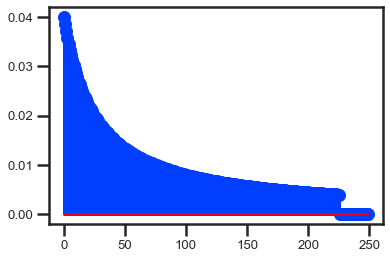

In [10]:
kernel = np.ones(5)

plt.stem(np.convolve(kernel, us, mode='same'))

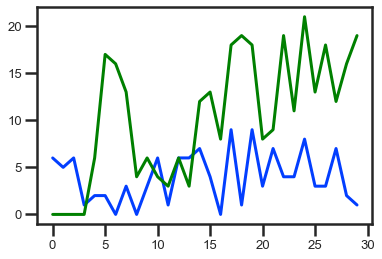

In [20]:
filter_kernel = np.zeros(10)
filter_kernel[0] = 2
filter_kernel[1] = 1

time_series = np.random.randint(0, 10, size=30)

plt.plot(time_series)
plt.plot(np.convolve(filter_kernel[::-1], time_series, 'same'), color='green')

<StemContainer object of 3 artists>

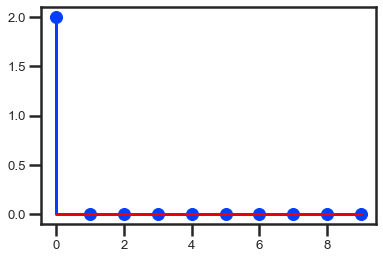

In [19]:
plt.stem(filter_kernel)

In [27]:
kernel = np.ones(3)
#kernel[0] = 10

x = np.arange(1, 10)
print(x)
print(np.convolve(kernel, x))

[1 2 3 4 5 6 7 8 9]
[ 1.  3.  6.  9. 12. 15. 18. 21. 24. 17.  9.]
